In [1]:
import math
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt

In [2]:
# Load the selected 10 bond into our workspace
df = pd.read_csv('selected_bond_data.csv')

# Change the string datatime into datetime type
df['Maturity date'] = pd.to_datetime(df['Maturity date'])
df['Issue date'] = pd.to_datetime(df['Issue date'])

# Set the period of half year period len to 180
PERIOD_LEN = 180
YEAR_LEN = 360
DATE_LST = df.columns[5:]
FACE_VALUE = 100

In [3]:
# Calculate the value of the bond using discounted cash flow
def bond_pv(c, f, ttm, ytm):
    # Since it is couponed semi-annually, we consider time as number of half years
    n = ttm/PERIOD_LEN
    total_value = f / ((1+ytm/2)**n)
    while n > 0:
        total_value += c / ((1+ytm/2)**n)
        n += -1
    return total_value

# Get the dity price of the bond
def bond_dirty_price(ttm, c, p):
    d_after_lastc = abs(ttm % PERIOD_LEN)
    acc_interest = c* (d_after_lastc / PERIOD_LEN)
    return p + acc_interest


# Draw the ytm graph and calculate the ytm for the bond.
def cal_ytm(df):
    
    df_ytm = pd.DataFrame()
    df_ytm['Maturity'] = df['Maturity date']
    
    for date_str in DATE_LST:
        daily_ytm = []
        dates = pd.to_datetime(date_str)
        for index, row in df.iterrows():
            c = row['Coupon rate']*FACE_VALUE / 2
            f = FACE_VALUE
            ttm = (row['Maturity date'] - dates).days
            p = row[date_str]
            ytm = lambda r: bond_pv(c,f,ttm,r)-bond_dirty_price(ttm,c,p)
            result = optimize.newton(ytm, 0.0001)
            daily_ytm.append(result*100)
        
        df_ytm[date_str] = daily_ytm
    
    # Draw the YTM graphs:

    # Plot yield curve
    df_ytm = df_ytm.set_index('Maturity')
    df_ytm.plot(title="5 year CAN Yield Curve")
    plt.xlabel("Time to Maturity / Years")
    plt.ylabel("Annually Yield to Maturity(%)")

    return df_ytm

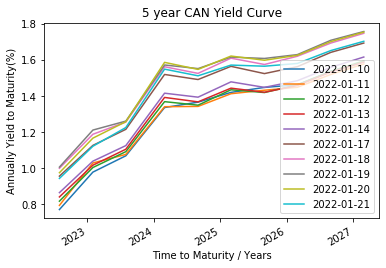

In [4]:
# Print the graph of the 5 Year Yield Curve
ytm_df = cal_ytm(df)

In [5]:
# Plot spot curve and get spot rates
def spot_rates(df):
    spot_df = []
    dates_lst = []
    
    for date_str in DATE_LST:
        dates_lst.append(date_str)
        single_spot = pd.DataFrame()
        spot_col = []
        time_col = []
        col_date = pd.to_datetime(date_str)
        for index, row in df.iterrows():
            ttm = (row['Maturity date'] - col_date).days
            years = ttm/YEAR_LEN
            c = row['Coupon rate']*FACE_VALUE / 2
            f = FACE_VALUE
            p = row[date_str]
            dirty_price = bond_dirty_price(ttm,c,p)
            
            if years < 0.5:
                spot_rate = (-math.log(dirty_price/(f+c)))/ years
            else:
                coupon_payments = 0
                for t in range(len(spot_col)):
                    coupon_payments += c*math.exp(-(spot_col[t]/100)*time_col[t])
                
                spot_rate = (-math.log((dirty_price-coupon_payments)/(f+c)))/years
            
            time_col.append(years)
            spot_col.append(spot_rate*100)
        
        # Add time and spot rates to dataframe
        single_spot['Time to Maturity'] = time_col
        single_spot['Spot Rate'] = spot_col
        spot_df.append(single_spot)
    
    # Plot the spot curve
    x_axis = spot_df[0].plot(x='Time to Maturity', y='Spot Rate',
                             label=dates_lst[0], title="5 year CAN Spot Curve")
    plt.ylabel("Spot Rate (%)")
    
    for i in range(1,len(spot_df)):
        spot_df[i].plot(x='Time to Maturity', y='Spot Rate', ax=x_axis, label=dates_lst[i])

    return spot_df, dates_lst

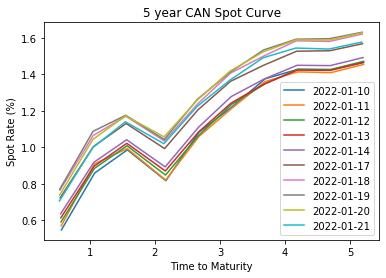

In [6]:
# Print the Spot Curve
spot_rates, DATES_LST = spot_rates(df)

In [7]:
# Calculate the forward rates and draw the graph of the forward rate
def cal_forward(df_spot, dates_lst):
    results = []
    
    for i in range(len(df_spot)):
        df_forward = pd.DataFrame()
        time_col = []
        forward_col = []

        df = df_spot[i]
        t = list(df['Time to Maturity'])
        spot_rate = list(df['Spot Rate'])

        r_1 = np.interp(1,t,spot_rate)
        for i in range(2,6):
            r_i = np.interp(i,t,spot_rate)
            time_col.append(i-1)
            forward_col.append((r_i*i-r_1)/(i-1))
            
        df_forward['Time to Maturity'] = time_col
        df_forward['Forward Rate'] = forward_col
        results.append(df_forward)
    
    # Draw the forward rates curve
    x_axis = results[0].plot(x='Time to Maturity', y='Forward Rate', 
                             label=dates_lst[0], title="1yr CAN Forward Curve")
    plt.ylabel("Forward Rate (%)")
    
    for i in range(1, len(results)):
        results[i].plot(x='Time to Maturity', y='Forward Rate', 
                        ax=x_axis, label=dates_lst[i])

    return results

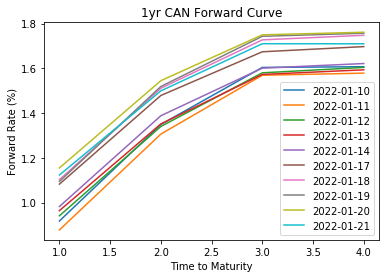

In [8]:
forward_rates = cal_forward(spot_rates, DATES_LST)

In [9]:
def cov_matrix(data_lst):
    matrix = np.array(data_lst).T
    matrix = np.log(matrix)
    matrix = np.diff(matrix)
    
    matrix = matrix.T
    matrix_mean = np.mean(matrix, axis=0)
    num_ele = matrix.shape[0]
    result = np.dot((matrix - matrix_mean).T, (matrix - matrix_mean))/(num_ele - 1)
    return result

In [10]:
# Calculate covarince matrix for log-returns of yield
def cov_ytm(df_ytm):
    ytm_matrix = []
    for date_str in df_ytm.columns:
        dates = pd.to_datetime(date_str)
        r_col = []
        for i in range(1,6):
            maturity = (dates + pd.offsets.DateOffset(years=i)).timestamp()
            x = [j.timestamp() for j in list(df_ytm.index)]
            y = list(df_ytm[date_str])
            r_maturity = np.interp(maturity,x,y)
            r_col.append(r_maturity)
        ytm_matrix.append(r_col)

    return cov_matrix(ytm_matrix)

In [11]:
ytm_cov_matrix = cov_ytm(ytm_df)
print("The covariance for YTM is:")
print(ytm_cov_matrix)

The covariance for YTM is:
[[0.00176903 0.00081459 0.00074468 0.00075631 0.00070466]
 [0.00081459 0.00068    0.00062675 0.0005666  0.00055478]
 [0.00074468 0.00062675 0.00061275 0.00056786 0.00055222]
 [0.00075631 0.0005666  0.00056786 0.00056074 0.00053567]
 [0.00070466 0.00055478 0.00055222 0.00053567 0.00052099]]


In [12]:
# Find covariance matrix for the calculated forward rates
def cov_forward(df_forward):
    forward_matrix = []
    for i in range(len(df_forward)):
        df = df_forward[i]
        forward_matrix.append(list(df['Forward Rate']))

    return cov_matrix(forward_matrix)

In [13]:
forward_cov_matrix = cov_forward(forward_rates)
print("The covariance for the forward rates is:")
print(forward_cov_matrix)

The covariance for the forward rates is:
[[0.00208139 0.00122339 0.00073971 0.00082189]
 [0.00122339 0.00086584 0.00060919 0.00064452]
 [0.00073971 0.00060919 0.00050196 0.00051298]
 [0.00082189 0.00064452 0.00051298 0.00054572]]


In [14]:
def print_results(eigenv, eigenvec, name):
    print("The eigenvalues for covariance matrix of "+name+" are:")
    print(eigenv)
    print("-"*50)
    print("Their corresponding eigenvectors are:")
    print(eigenvec)
    print("-"*50)
    print("More specifically:")
    for i in range(len(eigenv)):
        value = eigenv[i]
        vector = eigenvec.T[i]
        print("The eigenvector for "+ str(eigenv[i])+ " is:")
        print(vector)
        print("-"*50)

In [15]:
ytm_eigen_values, ytm_eigen_vectors = np.linalg.eig(ytm_cov_matrix)
YTM_NAME = "YTM"
print_results(ytm_eigen_values, ytm_eigen_vectors,YTM_NAME)

The eigenvalues for covariance matrix of YTM are:
[3.56965911e-03 5.02104452e-04 6.20971234e-05 5.93533183e-06
 3.71604620e-06]
--------------------------------------------------
Their corresponding eigenvectors are:
[[-0.64304077 -0.7638437  -0.00275997  0.04181928  0.03584554]
 [-0.40789234  0.31735568 -0.74567186 -0.39027975 -0.15673034]
 [-0.38757067  0.37858591 -0.08855649  0.82259224  0.14819395]
 [-0.3755038   0.27488297  0.53201501 -0.12058409 -0.69703354]
 [-0.35903799  0.31135228  0.39125903 -0.39336288  0.68288615]]
--------------------------------------------------
More specifically:
The eigenvector for 0.0035696591074107276 is:
[-0.64304077 -0.40789234 -0.38757067 -0.3755038  -0.35903799]
--------------------------------------------------
The eigenvector for 0.0005021044521719295 is:
[-0.7638437   0.31735568  0.37858591  0.27488297  0.31135228]
--------------------------------------------------
The eigenvector for 6.209712338507451e-05 is:
[-0.00275997 -0.74567186 -0.08855

In [16]:
for_eigen_values, for_eigen_vectors = np.linalg.eig(forward_cov_matrix)
FORWARD_NAME = "Forward Rates"
print_results(for_eigen_values, for_eigen_vectors,FORWARD_NAME)

The eigenvalues for covariance matrix of Forward Rates are:
[3.61116644e-03 3.58942495e-04 1.74798069e-05 7.32633696e-06]
--------------------------------------------------
Their corresponding eigenvectors are:
[[ 0.73269266  0.62852302  0.2186679  -0.1424943 ]
 [ 0.48178066 -0.21281288 -0.77493726  0.34938564]
 [ 0.32685807 -0.55833178  0.01280074 -0.76240775]
 [ 0.35243816 -0.49793084  0.59286823  0.52569904]]
--------------------------------------------------
More specifically:
The eigenvector for 0.0036111664428477115 is:
[0.73269266 0.48178066 0.32685807 0.35243816]
--------------------------------------------------
The eigenvector for 0.0003589424953343965 is:
[ 0.62852302 -0.21281288 -0.55833178 -0.49793084]
--------------------------------------------------
The eigenvector for 1.7479806918126152e-05 is:
[ 0.2186679  -0.77493726  0.01280074  0.59286823]
--------------------------------------------------
The eigenvector for 7.326336955522099e-06 is:
[-0.1424943   0.34938564 -0.76